In [11]:
import os
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [12]:
device = torch.device('cuda:0')
device

device(type='cuda', index=0)

In [13]:
torch.zeros(1, device=device)

tensor([0.], device='cuda:0')

In [14]:
model = torch.hub.load('../yolov5', 'custom', source='local')
model.to(device)

YOLOv5 🚀 v6.2-211-g32a9218 Python-3.10.6 torch-1.14.0.dev20221027 CUDA:0 (NVIDIA GeForce RTX 3090 Ti, 24253MiB)

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
Adding AutoShape... 


AutoShape(
  (model): DetectMultiBackend(
    (model): DetectionModel(
      (model): Sequential(
        (0): Conv(
          (conv): Conv2d(3, 16, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
          (act): SiLU(inplace=True)
        )
        (1): Conv(
          (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
        (2): C3(
          (cv1): Conv(
            (conv): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv2): Conv(
            (conv): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv3): Conv(
            (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (m): Sequential(
            (0): Bottleneck(
              (cv1): Conv(
                (conv): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
  

In [15]:
def processDetection(im, xyxy, traces={}):
    size = xyxy.shape[0]
    if size == 0:
        return im, {}

    for index, row in xyxy.iterrows():
        xmin = row['xmin']
        xmax = row['xmax']
        ymin = row['ymin']
        ymax = row['ymax']
        cls = row['class']

        if not (cls in traces.keys()): 
            traces[cls] = []


        rect_start = np.array([xmin, ymin])
        rect_end = np.array([xmax, ymax])

        center = rect_start + (rect_end - rect_start) / 2

        # following trace, check if it's possible
        if len(traces[cls]) > 0:
            last = traces[cls][-1]
            
            distance = np.sqrt(
                np.sum(np.abs(center - last))
            )

            if distance < 20:
                traces[cls].append(center)
            else:
                if len(traces[cls]) == 1:
                    traces[cls].pop()
                    traces[cls].append(center)


        # first point of the trace
        else:
            traces[cls].append(center)

        im = cv2.rectangle(im, rect_start.astype(np.uint), rect_end.astype(np.uint), color=(0, 255, 0), thickness=2)
        # im = cv2.circle(im, center.astype(np.uint), radius=1, color=(255, 0, 0), thickness=6)

        for cls in traces:
            trace = np.array(traces[cls]).reshape(-1, 1, 2).astype(np.int32)
            im = cv2.polylines(im, [trace], False, (0, 0, 255), 6)
    
    return im, traces

In [16]:
cap = cv2.VideoCapture('../videos/videos_partA.mp4')
fps = cap.get(cv2.CAP_PROP_FPS)
height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)

In [17]:
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
output = cv2.VideoWriter('./output.mp4', fourcc, fps, np.array([width, height], dtype=np.uint))

In [18]:
from nis import cat


success, img = cap.read()
fno = 0

frames = []
traces = {}
while success:
    success, img = cap.read()
    if not success: 
        break

    bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    frames.append(bgr)
    copy = bgr.copy()

    results = model(bgr)
    xyxy = results.pandas().xyxy[0]

    processed, traces = processDetection(copy, xyxy, traces)

    processed = cv2.cvtColor(processed, cv2.COLOR_BGR2RGB) 
    output.write(processed)

In [19]:
cap.release()
output.release()

In [20]:
img = cv2.imread('../videos/images/hand_val0003.jpg')
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

FileNotFoundError: [Errno 2] No such file or directory: '../videos/images/hand_val0003.jpg'

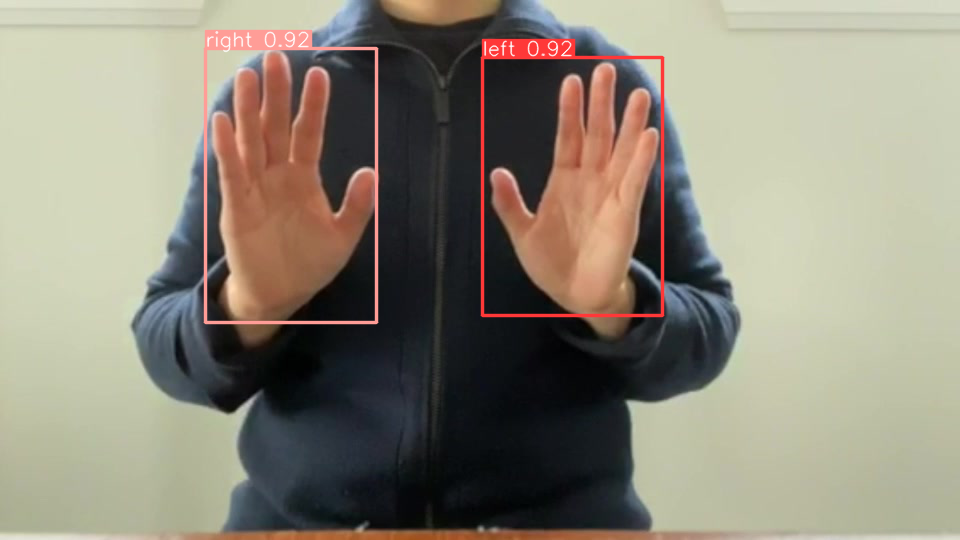

In [ ]:
results = model(img)
results.show()

In [ ]:
results = model('../videos/videos_partA.mp4')
results.show()

UnidentifiedImageError: cannot identify image file '../videos/videos_partA.mp4'

In [ ]:
%matplotlib inline
plt.imshow(img2)
plt.show()

NameError: name 'img2' is not defined

In [ ]:
a = np.array([[579.63, 487.55], [579.63, 487.55], [579.63, 487.55], [579.63, 487.55]]).reshape(-1, 1, 2)
a

array([[[     579.63,      487.55]],

       [[     579.63,      487.55]],

       [[     579.63,      487.55]],

       [[     579.63,      487.55]]])

In [ ]:
img = cv2.imread('../videos/images/hand0003.jpg')
img2 = cv2.polylines(img, [a], False, (0, 0, 255), 6)

error: OpenCV(4.5.5) /home/conda/feedstock_root/build_artifacts/libopencv_1654062598218/work/modules/imgproc/src/drawing.cpp:2428: error: (-215:Assertion failed) p.checkVector(2, CV_32S) >= 0 in function 'polylines'


In [ ]:
a =  [1,2,3]

In [ ]:
a[0]

1

In [ ]:
a[0] = 2

In [ ]:
a = np.array([[     579.61,      487.06]])
b = np.array([[     579.61,      487.06]])

np.concatenate((a, b))

array([[     579.61,      487.06],
       [     579.61,      487.06]])

In [ ]:
a = np.zeros(1)
a

array([          0])

In [ ]:
a = {'a': 'b', 'c': 'd'}

In [ ]:
for key in a:
    print(key)

a
c
